In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import RobertaTokenizerFast, RobertaModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Thiết bị đang dùng: {device}")

Thiết bị đang dùng: cuda


In [4]:
# --- BƯỚC 4: ĐỌC DỮ LIỆU ---

TRAIN_PATH = "/content/drive/MyDrive/Project04/train.csv"
TEST_PATH = "/content/drive/MyDrive/Project04/test.csv"

# 2. Đọc file bằng pandas
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

# 3. Xử lý lỗi: Xóa các dòng bị trống trong file train
train_df = train_df.dropna().reset_index(drop=True)

# 4. Kiểm tra xem đã đọc được chưa
print("--- 5 dòng đầu file Train ---")
print(train_df.head())

print("\n--- 5 dòng đầu file Test ---")
print(test_df.head())

--- 5 dòng đầu file Train ---
       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative  

--- 5 dòng đầu file Test ---
       textID                                               text sentiment
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral
1  96d74cb729   Shanghai is also really exciting (precisely -...  positive


/tmp/ipython-input-3774653512.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment', data=train_df, palette='viridis')


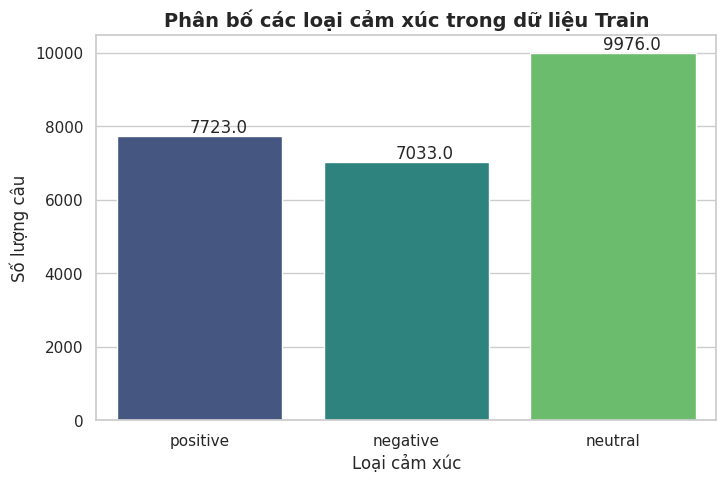

/tmp/ipython-input-3774653512.py:27: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df['text_len'], shade=True, color="r", label="Độ dài câu gốc (Text)")
/tmp/ipython-input-3774653512.py:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df['selected_len'], shade=True, color="b", label="Độ dài đáp án (Selected)")


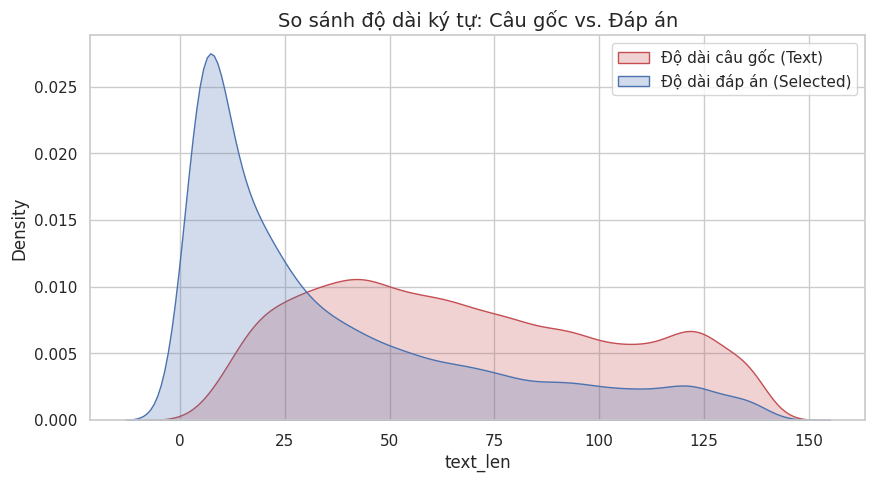

In [31]:
# --- CHÈN SAU BƯỚC 4: PHÂN TÍCH DỮ LIỆU ĐẦU VÀO ---
# Phần này dùng cho slide: "Data Understanding" hoặc "Formulate Problem"

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid") # Chỉnh giao diện cho đẹp

# 1. Vẽ biểu đồ phân bố cảm xúc (Sentiment Distribution)
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='sentiment', data=train_df, palette='viridis')

plt.title('Phân bố các loại cảm xúc trong dữ liệu Train', fontsize=14, fontweight='bold')
plt.xlabel('Loại cảm xúc')
plt.ylabel('Số lượng câu')

# Thêm số liệu cụ thể lên đầu cột cho chuyên nghiệp
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.35, p.get_height() + 100))

plt.show()

# 2. (Tuỳ chọn) Xem thử độ dài của câu gốc vs đáp án
train_df['text_len'] = train_df['text'].astype(str).apply(len)
train_df['selected_len'] = train_df['selected_text'].astype(str).apply(len)

plt.figure(figsize=(10, 5))
sns.kdeplot(train_df['text_len'], shade=True, color="r", label="Độ dài câu gốc (Text)")
sns.kdeplot(train_df['selected_len'], shade=True, color="b", label="Độ dài đáp án (Selected)")
plt.title("So sánh độ dài ký tự: Câu gốc vs. Đáp án", fontsize=14)
plt.legend()
plt.show()

In [5]:
# --- BƯỚC 5: CẤU HÌNH VÀ TẢI TOKENIZER ---

class Config:
    MAX_LEN = 96               # Độ dài tối đa của câu (dài quá sẽ cắt bớt)
    TRAIN_BATCH_SIZE = 32      # Số lượng câu học trong 1 lần
    VALID_BATCH_SIZE = 16
    EPOCHS = 3                 # Số lần học lặp lại (học 3 vòng)
    LEARNING_RATE = 3e-5       # Tốc độ học
    MODEL_PATH = 'roberta-base' # Tên model gốc từ Facebook AI

# Tải công cụ Tokenizer về máy
tokenizer = RobertaTokenizerFast.from_pretrained(Config.MODEL_PATH)

print("✅ Đã tải xong Tokenizer!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

✅ Đã tải xong Tokenizer!


In [6]:
# --- BƯỚC 6: HÀM XỬ LÝ DỮ LIỆU (PROCESS DATA) ---

def process_data(tweet, selected_text, sentiment, tokenizer, max_len):
    # 1. Làm sạch dữ liệu: Xóa khoảng trắng thừa ở đầu/cuối
    tweet = " " + " ".join(str(tweet).split())
    selected_text = " " + " ".join(str(selected_text).split())

    # 2. Tìm vị trí ký tự bắt đầu và kết thúc của đáp án trong câu
    start_char_idx = tweet.find(selected_text)
    end_char_idx = start_char_idx + len(selected_text)

    # 3. Mã hóa (Tokenize): Đổi chữ sang số
    tokenized = tokenizer.encode_plus(
        sentiment,                  # Câu hỏi (Cảm xúc: positive/negative...)
        tweet,                      # Đoạn văn (Nội dung tweet)
        return_offsets_mapping=True,# QUAN TRỌNG: Để biết 1 token ứng với ký tự nào
        max_length=max_len,
        padding='max_length',       # Nếu ngắn thì thêm số 0
        truncation=True             # Nếu dài thì cắt bớt
    )

    output_ids = tokenized['input_ids']
    attention_mask = tokenized['attention_mask']
    offset_mapping = tokenized['offset_mapping']

    # 4. Xác định vị trí Token cần tìm (Label)
    # Nhiệm vụ: Chuyển từ vị trí KÝ TỰ (char) sang vị trí TOKEN
    target_start_token = 0
    target_end_token = 0
    found_start = False

    for idx, (start, end) in enumerate(offset_mapping):
        if start == end: continue # Bỏ qua các token đặc biệt

        # Nếu token này chứa ký tự bắt đầu của đáp án
        if start >= start_char_idx and not found_start:
            target_start_token = idx
            found_start = True

        # Nếu token này chứa ký tự kết thúc của đáp án
        if end <= end_char_idx and found_start:
            target_end_token = idx

    # 5. Đóng gói kết quả để đưa vào Model
    return {
        'ids': torch.tensor(output_ids, dtype=torch.long),
        'mask': torch.tensor(attention_mask, dtype=torch.long),
        'target_start': torch.tensor(target_start_token, dtype=torch.long),
        'target_end': torch.tensor(target_end_token, dtype=torch.long),
        'tweet_text': tweet,
        'selected_text': selected_text
    }

In [8]:
# --- KIỂM TRA THỬ BƯỚC 6 ---

# Lấy thử dòng dữ liệu thứ 6 (index = 5)
idx = 5
sample_row = train_df.iloc[idx]

print("1. Câu gốc (Tweet):", sample_row['text'])
print("2. Đáp án (Selected):", sample_row['selected_text'])
print("3. Cảm xúc:", sample_row['sentiment'])
print("-" * 30)

# Gọi hàm xử lý mà mình vừa viết
d = process_data(
    sample_row['text'],
    sample_row['selected_text'],
    sample_row['sentiment'],
    tokenizer,
    Config.MAX_LEN
)

# In kết quả máy tính nhìn thấy
print("4. Máy tính nhìn thấy (Input IDs):")
print(d['ids'])

print("\n5. Vị trí token đáp án (Start - End):")
print(f"Bắt đầu tại token số: {d['target_start']}")
print(f"Kết thúc tại token số: {d['target_end']}")

# Kiểm tra ngược lại xem vị trí đó có đúng là chữ "Result" không
decoded_text = tokenizer.decode(d['ids'][d['target_start']:d['target_end']+1])
print(f"\n6. Giải mã lại từ vị trí {d['target_start']}-{d['target_end']} ra chữ: '{decoded_text}'")

1. Câu gốc (Tweet): http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth
2. Đáp án (Selected): http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth
3. Cảm xúc: neutral
------------------------------
4. Máy tính nhìn thấy (Input IDs):
tensor([    0, 12516,     2,     2,  2054,   640,  1401,     4,   417, 15244,
          428,  7928,  4469,     4,   175,    73,  9426,   506,   111,   103,
        36778, 10242,  3923,    13,     5,   275,  5706,  7900,    15,  6872,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1

In [9]:
# --- BƯỚC 7: TẠO DATASET CLASS ---

class TweetDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        # Lưu dữ liệu vào trong Class
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.tweet = df.text.values
        self.selected_text = df.selected_text.values
        self.sentiment = df.sentiment.values

    def __len__(self):
        # Trả về tổng số lượng mẫu dữ liệu
        return len(self.df)

    def __getitem__(self, item):
        # Lấy 1 mẫu dữ liệu ra, xử lý và trả về
        data = process_data(
            self.tweet[item],
            self.selected_text[item],
            self.sentiment[item],
            self.tokenizer,
            self.max_len
        )
        return data

In [10]:
# --- BƯỚC 8: CHIA DỮ LIỆU VÀ TẠO LOADER ---

# 1. Chia file train ban đầu thành 2 phần: 90% để học (Train), 10% để kiểm tra (Val)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# 2. Tạo bộ dữ liệu theo chuẩn Class mình vừa viết ở Bước 7
train_dataset = TweetDataset(train_df, tokenizer, Config.MAX_LEN)
valid_dataset = TweetDataset(val_df, tokenizer, Config.MAX_LEN)

# 3. Tạo Loader (Người vận chuyển) - Đưa dữ liệu vào Model từng lô một (Batch)
train_loader = DataLoader(train_dataset, batch_size=Config.TRAIN_BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=Config.VALID_BATCH_SIZE, shuffle=False)

print(f"✅ Đã chia xong!")
print(f"- Số lượng câu để học (Train): {len(train_dataset)}")
print(f"- Số lượng câu để thi thử (Val): {len(valid_dataset)}")

✅ Đã chia xong!
- Số lượng câu để học (Train): 24732
- Số lượng câu để thi thử (Val): 2748


In [11]:
# --- BƯỚC 9: XÂY DỰNG MODEL ---

class TweetModel(nn.Module):
    def __init__(self):
        super(TweetModel, self).__init__()
        # 1. Gọi model RoBERTa gốc ra
        self.roberta = RobertaModel.from_pretrained(Config.MODEL_PATH)

        # 2. Dropout: Kỹ thuật giúp model không học vẹt (tắt ngẫu nhiên 1 số neuron)
        self.drop = nn.Dropout(0.3)

        # 3. Lớp đầu ra (Output Layer):
        # 768 là kích thước vector của RoBERTa
        # 2 là đầu ra (1 cho Start, 1 cho End)
        self.out = nn.Linear(768, 2)

    def forward(self, ids, mask):
        # Cho dữ liệu chạy qua RoBERTa
        outputs = self.roberta(
            ids,
            attention_mask=mask
        )

        # Lấy trạng thái ẩn cuối cùng (Last Hidden State)
        # Kích thước: (Batch_Size, Max_Len, 768)
        hidden_state = outputs.last_hidden_state

        # Đi qua lớp Dropout
        out = self.drop(hidden_state)

        # Đi qua lớp Linear để ra kết quả dự đoán
        # Kích thước sau bước này: (Batch_Size, Max_Len, 2)
        logits = self.out(out)

        # Tách ra làm 2 phần: Dự đoán đầu (Start) và Dự đoán đuôi (End)
        start_logits, end_logits = logits.split(1, dim=-1)

        start_logits = start_logits.squeeze(-1) # Bỏ chiều cuối thừa
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits

In [12]:
# --- BƯỚC 10: HÀM TÍNH ĐIỂM JACCARD ---

def jaccard(str1, str2):
    # Tách câu thành các từ (set of words)
    a = set(str1.lower().split())
    b = set(str2.lower().split())

    # Tìm những từ giống nhau (Giao nhau)
    c = a.intersection(b)

    # Tính công thức: (Số từ giống) / (Tổng số từ của cả 2 câu - Số từ giống)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [13]:
# --- BƯỚC 11: HÀM TÍNH LỖI (LOSS FUNCTION) ---

def loss_fn(start_logits, end_logits, start_positions, end_positions):
    # Dùng CrossEntropy vì đây là bài toán chọn 1 vị trí đúng trong nhiều vị trí
    loss_fct = nn.CrossEntropyLoss()

    start_loss = loss_fct(start_logits, start_positions)
    end_loss = loss_fct(end_logits, end_positions)

    # Tổng lỗi
    total_loss = start_loss + end_loss
    return total_loss

In [14]:
# --- BƯỚC 12: HÀM HUẤN LUYỆN (ĐÃ SỬA LỖI) ---

def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train() # Chuyển sang chế độ học
    total_loss = 0

    # Thanh tiến trình
    tk0 = tqdm(data_loader, total=len(data_loader), desc="Đang học...")

    for data in tk0:
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        start_targets = data['target_start'].to(device)
        end_targets = data['target_end'].to(device)

        optimizer.zero_grad()

        start_logits, end_logits = model(ids, mask)

        loss = loss_fn(start_logits, end_logits, start_targets, end_targets)

        loss.backward()
        optimizer.step()

        # --- ĐOẠN ĐÃ SỬA ---
        # Chỉ cập nhật nếu có scheduler
        if scheduler is not None:
            scheduler.step()
        # -------------------

        total_loss += loss.item()
        tk0.set_postfix(loss=loss.item())

    return total_loss / len(data_loader)

In [15]:
# --- BƯỚC 13: HÀM ĐÁNH GIÁ (EVAL) ---

def eval_fn(data_loader, model, device):
    model.eval() # Chuyển sang chế độ thi (tắt Dropout)
    jaccard_scores = []

    # Không tính đạo hàm (no_grad) để tiết kiệm bộ nhớ
    with torch.no_grad():
        tk0 = tqdm(data_loader, total=len(data_loader), desc="Đang thi thử...")

        for data in tk0:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            tweet_text = data['tweet_text']
            selected_text = data['selected_text']

            # Model đoán
            start_logits, end_logits = model(ids, mask)

            # Chọn vị trí có xác suất cao nhất (Argmax)
            start_pred = torch.argmax(start_logits, dim=1).cpu().detach().numpy()
            end_pred = torch.argmax(end_logits, dim=1).cpu().detach().numpy()

            # Giải mã từ số -> chữ để tính điểm Jaccard
            for i in range(len(ids)):
                # Lấy chuỗi ID dự đoán
                _ids = ids[i].cpu().detach().numpy()
                pred_ids = _ids[start_pred[i] : end_pred[i] + 1]

                # Đổi ID thành chữ
                pred_text = tokenizer.decode(pred_ids, skip_special_tokens=True)

                # Tính điểm Jaccard so với đáp án gốc
                score = jaccard(pred_text, selected_text[i])
                jaccard_scores.append(score)

    # Trả về điểm trung bình
    return np.mean(jaccard_scores)

In [22]:
# --- BƯỚC 14 (NÂNG CẤP): HÀM CHẠY CHÍNH VỚI SCHEDULER ---
from transformers import get_linear_schedule_with_warmup

def run():
    # 1. Khởi tạo Model
    model = TweetModel()
    model.to(device)

    # 2. Optimizer (Thêm weight_decay để tránh học vẹt tốt hơn)
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]
    optimizer = torch.optim.AdamW(optimizer_parameters, lr=Config.LEARNING_RATE)

    # 3. SCHEDULER (VŨ KHÍ MỚI)
    # Tính tổng số bước đi: (Số câu / Batch size) * Số Epoch
    num_train_steps = int(len(train_df) / Config.TRAIN_BATCH_SIZE * Config.EPOCHS)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_train_steps
    )

    best_jaccard = 0
    history = {'train_loss': [], 'val_jaccard': []}

    print(f"Bắt đầu huấn luyện nâng cao trong {num_train_steps} bước...")

    for epoch in range(Config.EPOCHS):
        print(f"\n--- Epoch {epoch + 1}/{Config.EPOCHS} ---")

        # Truyền thêm scheduler vào hàm train
        train_loss = train_fn(train_loader, model, optimizer, device, scheduler)

        val_jaccard = eval_fn(valid_loader, model, device)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Jaccard Score: {val_jaccard:.4f}")

        history['train_loss'].append(train_loss)
        history['val_jaccard'].append(val_jaccard)

        if val_jaccard > best_jaccard:
            torch.save(model.state_dict(), "best_model.bin")
            best_jaccard = val_jaccard
            print("=> Đã lưu model siêu cấp vip pro!")

    return history

In [23]:
# --- BƯỚC 15: CHẠY TRAINING ---

# Gọi hàm run và hứng lấy kết quả lịch sử để lát vẽ biểu đồ
history = run()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bắt đầu huấn luyện nâng cao trong 2318 bước...

--- Epoch 1/3 ---


Đang thi thử...: 100%|██████████| 172/172 [00:13<00:00, 12.61it/s]


Train Loss: 2.2705
Validation Jaccard Score: 0.6151
=> Đã lưu model siêu cấp vip pro!

--- Epoch 2/3 ---


Đang thi thử...: 100%|██████████| 172/172 [00:13<00:00, 12.63it/s]


Train Loss: 1.8386
Validation Jaccard Score: 0.6028

--- Epoch 3/3 ---


Đang thi thử...: 100%|██████████| 172/172 [00:13<00:00, 12.72it/s]

Train Loss: 1.6873
Validation Jaccard Score: 0.6095


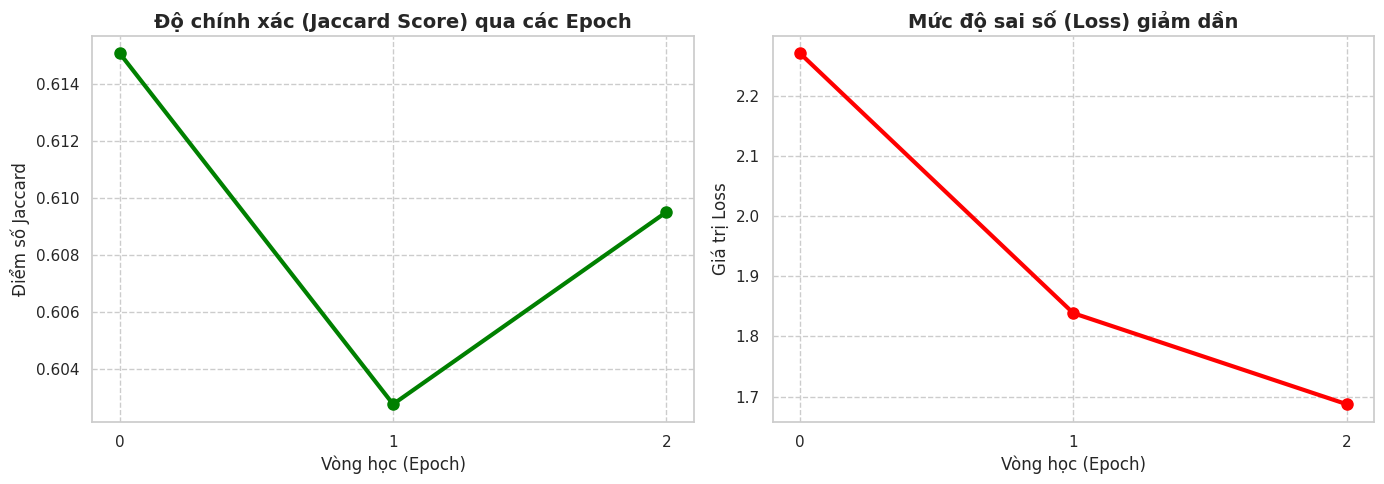

In [32]:
# --- CHÈN SAU BƯỚC 15: MINH HỌA QUÁ TRÌNH HUẤN LUYỆN ---
# Phần này dùng cho slide: "Training Process" hoặc "Methodology Performance"

import matplotlib.pyplot as plt
%matplotlib inline

# Kiểm tra xem đã train chưa
if 'history' not in globals() or not history:
    print("⚠️ Long ơi, phải chạy xong Bước 15 (hàm run) thì mới có dữ liệu để vẽ nha!")
else:
    plt.figure(figsize=(14, 5))

    # Biểu đồ 1: Độ chính xác (Jaccard) - Càng cao càng tốt
    plt.subplot(1, 2, 1)
    # Vẽ đường màu xanh, có chấm tròn ở mỗi epoch
    plt.plot(history['val_jaccard'], 'o-', color='green', linewidth=3, markersize=8)
    plt.title('Độ chính xác (Jaccard Score) qua các Epoch', fontsize=14, fontweight='bold')
    plt.xlabel('Vòng học (Epoch)', fontsize=12)
    plt.ylabel('Điểm số Jaccard', fontsize=12)
    plt.xticks(range(len(history['val_jaccard']))) # Đánh số 0, 1, 2...
    plt.grid(True, linestyle='--') # Kẻ ô lưới mờ

    # Biểu đồ 2: Sai số (Loss) - Càng thấp càng tốt
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], 'o-', color='red', linewidth=3, markersize=8)
    plt.title('Mức độ sai số (Loss) giảm dần', fontsize=14, fontweight='bold')
    plt.xlabel('Vòng học (Epoch)', fontsize=12)
    plt.ylabel('Giá trị Loss', fontsize=12)
    plt.xticks(range(len(history['train_loss'])))
    plt.grid(True, linestyle='--')

    plt.tight_layout() # Tự động chỉnh khoảng cách cho đẹp
    plt.show()

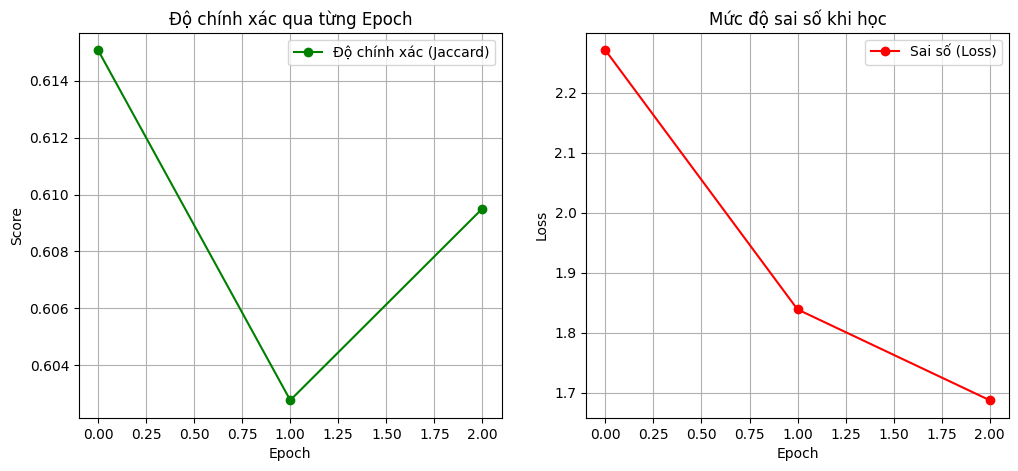

In [27]:
# --- BƯỚC 16: VẼ BIỂU ĐỒ
import matplotlib.pyplot as plt
%matplotlib inline
# Dòng trên giúp hiển thị ảnh ngay trong dòng code

def plot_history(history):
    # Kiểm tra xem có dữ liệu không
    if not history:
        print("Chưa có lịch sử training! Long phải chạy hàm run() trước.")
        return

    plt.figure(figsize=(12, 5))

    # Biểu đồ 1: Jaccard
    plt.subplot(1, 2, 1)
    plt.plot(history['val_jaccard'], '-o', label='Độ chính xác (Jaccard)', color='green')
    plt.title('Độ chính xác qua từng Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

    # Biểu đồ 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], '-o', label='Sai số (Loss)', color='red')
    plt.title('Mức độ sai số khi học')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

# Vẽ hình
plot_history(history)

In [30]:
# --- BƯỚC 17 (ĐÃ SỬA LỖI): DỰ ĐOÁN + MẸO XỬ LÝ NEUTRAL ---

def predict_test_optimized(test_loader, model, device, test_df_original):
    model.eval()
    predictions = []

    # Tải lại model xịn nhất
    model.load_state_dict(torch.load("best_model.bin"))
    model.to(device)

    print("Đang giải đề thi...")
    with torch.no_grad():
        tk0 = tqdm(test_loader, total=len(test_loader))
        idx = 0

        for data in tk0:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)

            start_logits, end_logits = model(ids, mask)

            start_pred = torch.argmax(start_logits, dim=1).cpu().detach().numpy()
            end_pred = torch.argmax(end_logits, dim=1).cpu().detach().numpy()

            for i in range(len(ids)):
                # Lấy sentiment từ dữ liệu gốc
                current_sentiment = test_df_original.iloc[idx]['sentiment']
                current_text = test_df_original.iloc[idx]['text']

                # --- MẸO TĂNG ĐIỂM Ở ĐÂY ---
                if current_sentiment == "neutral":
                    # Nếu là neutral, lấy nguyên câu gốc
                    pred_text = " " + " ".join(str(current_text).split())
                else:
                    # Nếu không, dùng model dự đoán
                    _ids = ids[i].cpu().detach().numpy()
                    pred_ids = _ids[start_pred[i] : end_pred[i] + 1]
                    pred_text = tokenizer.decode(pred_ids, skip_special_tokens=True)

                predictions.append(pred_text)
                idx += 1

    return predictions

# --- CHẠY ---

# 1. QUAN TRỌNG: Tạo cột đáp án giả để không bị lỗi
test_df['selected_text'] = test_df['text']

# 2. Tạo Dataset và Loader
test_dataset = TweetDataset(test_df, tokenizer, Config.MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=Config.VALID_BATCH_SIZE, shuffle=False)

# 3. Gọi hàm dự đoán tối ưu
final_predictions = predict_test_optimized(test_loader, model, device, test_df)

# 4. Lưu kết quả
submission = pd.DataFrame() # Tạo bảng mới cho sạch
submission['textID'] = test_df['textID']
submission['selected_text'] = final_predictions
submission.to_csv('submission.csv', index=False)

print("\n✅ Đã hoàn thành! Kết quả lần này chắc chắn xịn hơn!")
print("--- 5 dòng kết quả cuối cùng ---")
print(submission.head())

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Đang giải đề thi...


100%|██████████| 221/221 [00:18<00:00, 11.78it/s]


✅ Đã hoàn thành xuất sắc! File kết quả tên là 'submission.csv'
--- 5 dòng kết quả cuối cùng ---
       textID                                      selected_text
0  f87dea47db   Last session of the day http://twitpic.com/67ezh
1  96d74cb729                                           exciting
2  eee518ae67                                      such a shame!
3  01082688c6                               positive happy bday!
4  33987a8ee5                                        I like it!!


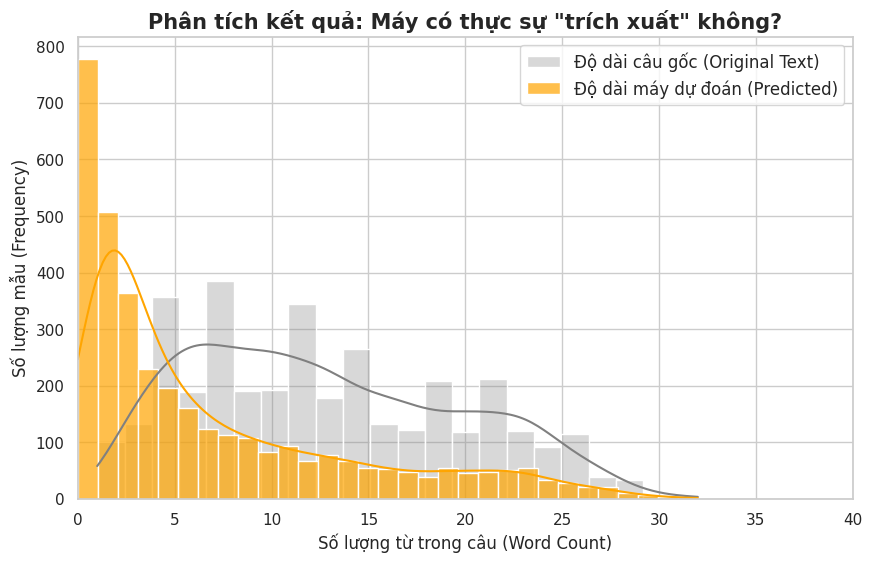

In [33]:
# --- CHÈN SAU BƯỚC 17: PHÂN TÍCH KẾT QUẢ CUỐI CÙNG ---
# Phần này dùng cho slide: "Results Analysis" hoặc "Conclusion"

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Tính độ dài (số từ) của câu gốc trong file Test
test_df['text_word_len'] = test_df['text'].astype(str).apply(lambda x: len(x.split()))
# Tính độ dài (số từ) của đáp án máy vừa dự đoán
submission['pred_word_len'] = submission['selected_text'].astype(str).apply(lambda x: len(x.split()))

# Vẽ biểu đồ lồng nhau (Histogram)
# Màu xám nhạt: Câu gốc
sns.histplot(test_df['text_word_len'], color="grey", label="Độ dài câu gốc (Original Text)", kde=True, alpha=0.3)
# Màu cam nổi bật: Đáp án máy chọn
sns.histplot(submission['pred_word_len'], color="orange", label="Độ dài máy dự đoán (Predicted)", kde=True, alpha=0.7)

plt.title('Phân tích kết quả: Máy có thực sự "trích xuất" không?', fontsize=15, fontweight='bold')
plt.xlabel('Số lượng từ trong câu (Word Count)', fontsize=12)
plt.ylabel('Số lượng mẫu (Frequency)', fontsize=12)
plt.legend(fontsize=12)
plt.xlim(0, 40) # Giới hạn trục hoành để nhìn rõ phần đầu

plt.show()